<h1>Project 4: Advanced Lane Finding</h1>

Solution Video: https://www.youtube.com/watch?v=OvadpMIeJMg

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

<h2>Importing the chessboard images for calibration</h2>

In [2]:
##Calibration using the chessboards provided
calib_dir = 'C:\\Users\\Syed\\Documents\\Proj4\\camera_cal\\'

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

objpoints = []
imgpoints = []

images = glob.glob(calib_dir + 'calibration*.jpg')
calibrated = []
for fname in images:
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    if ret == True:
        calibrated.append(fname)
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

<h2>Camera Calibration:</h2>

The way I calibrated the camera was that I took the 9x6 chessboard images provided, converting them to grayscale and finding their corners, using OpenCV’s findChessboardCorners function. This function returns the pixel location (i.e. imgpoints) for each square on the chessboard. I created a objpoints array which has the same values for every position in the array. These values represent all the coordinates for every square in the chessboard in the real world. I used the grayscale of the original distorted image, along with the imgpoints and the objpoints and OpenCV’s calibrateCamera function, returning several variables, including the distortion coefficients (i.e. dist) and the camera matrix (i.e. mtx). Using the original image, along with dist and mtx and OpenCV’s undistort function, I was able to retrieve an undistorted image of my original distorted image.

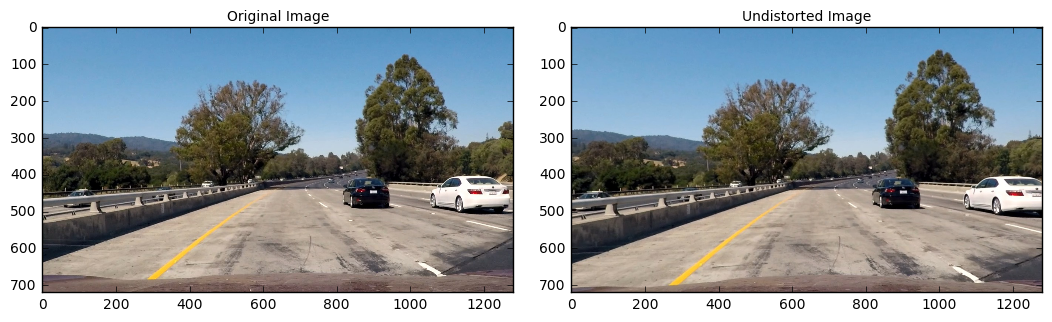

In [3]:
##Distortion Correction
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('test_images/test1.jpg')
undistorted_img = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<h2>Threshold:</h2>

In order to set the correct thresholds needed to really outline the lane line, a few things needed to be done. Firstly, I took the undistorted image and converted it to an HSL image, via OpenCV’s cvtColor function, and extracted the saturation channel from it. I also took the grayscale image of the undistorted image and took the derivative of it in the x-plane. The next step was to set thresholds on both the saturation and the x-plane derivative of the undistorted image. This step consisted of me manually trying and a few different values and seeing the output of my different combinations. In the end I settled with a minimum threshold of 50 and a maximum threshold for 100 for the x-derivative image and a minimum threshold of 90 and a maximum threshold of 255 for the saturation channel. Upon combining the 2 images after setting the thresholds on them, the result is a very suitable image, distinctly displaying the lane lines.

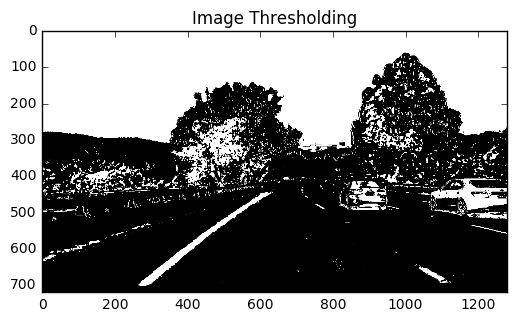

In [4]:
##Threshold combination
def get_threshold(img, s_thresh=[90,255], sx_thresh=[50,100]):
    #img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

threshold_img = get_threshold(undistorted_img)
plt.title('Image Thresholding')
plt.imshow(threshold_img, cmap='gray')

<h2>Isolating region:</h2>

After receiving the image showing the distinctive lane lines, I focused in on the region direction in front of the car, where the lane lines reside, in order to eliminate noise. I performed this via OpenCV’s fillpoly function.

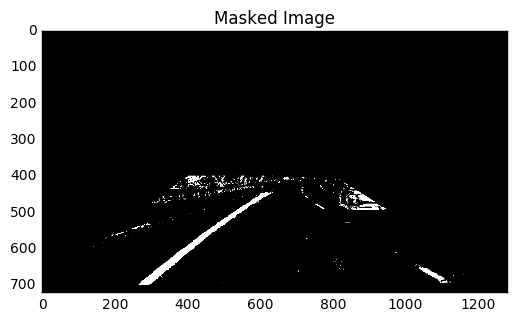

In [5]:
#get region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = [np.array([ [0,700], [400,400], [800,400], [1280,700] ], dtype=np.int32)]
masked_img = region_of_interest(threshold_img, vertices)

plt.title('Masked Image')
plt.imshow(masked_img, cmap='gray')

<h2>Warp image:</h2>

The image was then warped in order to carry out the actual finding the lane lines. 4 points were chosen on the unwarped image (source points), in the form of a trapezoid, and 4 points were chosen to where those source points would be transformed to be relocated (destination points). These steps were done with the help of OpenCV’s getPerspectiveTransform and warpPerspective functions. The getPerspectiveTransform function returns the coefficients needed to stretch/transform the original image in order to retrieve the desired results and warpPerspective takes those coefficients, along with the image and image size, and outputs the desired warped image. This warped image displays the lane line as if we were looking it at bird’s eye view.

<table>
  <tr>
    <th>Source Points</th>
    <th>Destination Points</th>
  </tr>
  <tr>
    <td>(280,695)</td>
    <td>(280,695)</td>
  </tr>
  <tr>
    <td>(545,495)</td>
    <td>(280,200)</td>
  </tr>
  <tr>
    <td>(1095,695)</td>
    <td>(1095,695)</td>
  </tr>
  <tr>
    <td>(765,495)</td>
    <td>(1095,200)</td>
  </tr>
</table>

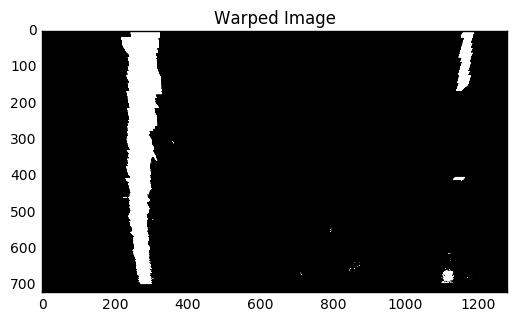

In [6]:
##Warp img
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])  
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

src = np.float32([[280,695],[545,495],[1095,695],[765,495]])
dst = np.float32([[280,695],[280,200],[1095,695],[1095,200]])
binary_warped = warp(masked_img, src, dst)

###############################################
##This will later be used to unwarp the image##
Minv = cv2.getPerspectiveTransform(dst, src)###
###############################################

plt.title('Warped Image')
plt.imshow(binary_warped, cmap='gray')

<h2>Find the Lane Lines:</h2>

The lane lines were found in several steps. First thing done was that I took the warped image and from its data points created a histogram. Since my thresholding and masking functions isolated the lane lines, making them distinctly the most visible lines, the peaks I receive are the most distinct lines (i.e. the lane lines). I split the image in 2, by the middle, making the assumption that the left peak given by the histogram was the left lane line and the right peak given by the histogram was the right lane line. Thereafter, I used 9 windows to go through the whole image and find the pixels corresponding to the peaks on the histogram and to return their coordinates. After going through the whole picture, the coordinates were used, along with OpenCV's polyfit function, to plot lines of second order polynomial curve over top the lane lines, showing that they've been correctly discovered/distinguished.

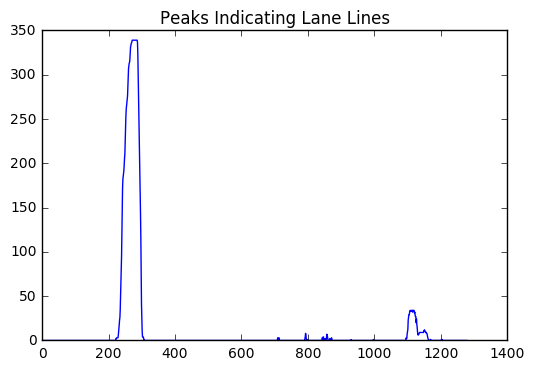

In [7]:
##find the lanes from scratch
def find_the_lines(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return histogram, left_lane_inds, right_lane_inds, left_fit, right_fit
    
##find the lanes from old lines
##due to lack of time, this function was not used in this assignment
def find_the_lines2(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit

histogram, left_lane_inds, right_lane_inds, left_fit, right_fit = find_the_lines(binary_warped)
plt.title('Peaks Indicating Lane Lines')
plt.plot(histogram)

(720, 0)

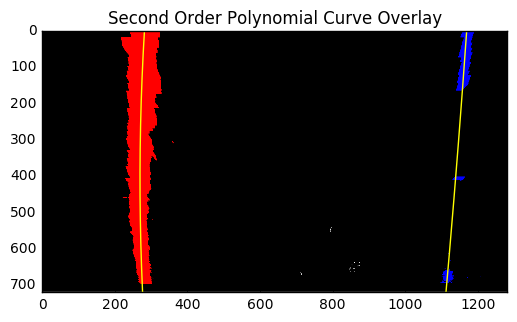

In [9]:
##generate values for plotting
def gen_plot_vals(binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return out_img, ploty, left_fitx, right_fitx

out_img, ploty, left_fitx, right_fitx = gen_plot_vals(binary_warped, left_fit, right_fit)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.title('Second Order Polynomial Curve Overlay')
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

<h2>Get the Curvature:</h2>

In order to make sure that our lane lines were correctly found, we get the curvature for it. By making use of an array which contains 720 (height of the image) evenly spaced samples, calculated over the interval 0 to 719 (this array being called ploty) along with the found lane line pixel coordinates, the curvature was found. In order to convert pixel measurements to real world measurements (in meters), we used the equation 30/720 for the y-values of the pixels and 3.7/700 for the x-values of the pixels Using all this information, I first found the radii of the curvature, thereafter converting it to meters and giving us our desired output.

In [10]:
##get curvature of lanes
def get_curvature(ploty, leftx, rightx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def get_middle_shift(left_fitx, right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    lane_middle = (((right_fitx-left_fitx)/2)+left_fitx)[0]
    car_middle = 1280/2
    if(lane_middle > car_middle):
        shift = lane_middle - car_middle
    else:
        shift = car_middle - lane_middle
    
    shift_in_m = shift*xm_per_pix
    return shift_in_m

left_curverad, right_curverad = get_curvature(ploty, left_fitx, right_fitx)
shift = get_middle_shift(left_fitx, right_fitx)
print("Shift from Center: "+ str(shift) + "m")
print("Left Curve Radius: " + str(left_curverad) + "m")
print("Right Curve Radius: " + str(right_curverad) + "m")

Shift from Center: 0.449303064382m
Left Curve Radius: 2238.18183294m
Right Curve Radius: 12744.6115422m


<h2>Draw Lane Lines:</h2>

Now comes the part of actually drawing the lane lines back on to the original distorted image. Since we're now certain that our curvature measurements are what we expect them to be, we can take those same pixel coordinates used for getting the measurements and outline them. Afterwards, for our lane lines to show on the original distorted image, we must work backwards in the order that it took to get to this step. First unwarp the image, then distort the image. Our dist points will now be our src points and vice versa. OpenCV's polyfill function is used to color the space between the found lane lines.

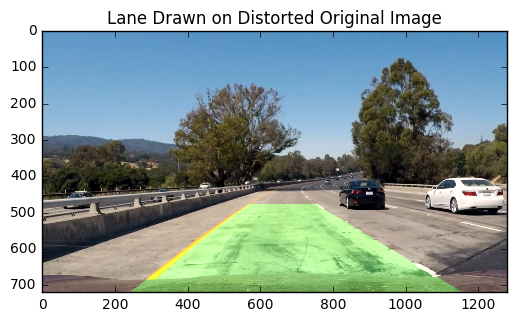

In [11]:
##draw lanes onto original image
def draw_lane(binary_warped, ploty, left_fitx, right_fitx, Minv, img, undistorted_img):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

result = draw_lane(binary_warped, ploty, left_fitx, right_fitx, Minv, img, img)
plt.title('Lane Drawn on Distorted Original Image')
plt.imshow(result)

In [12]:
prev_left_curverad = []
prev_right_curverad = []
prev_middle_shift = []
prev_ploty = []
prev_left_fitx = []
prev_right_fitx = []
def process_image(img):
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    threshold_img = get_threshold(undistorted_img)
    vertices = [np.array([ [0,700], [400,400], [800,400], [1280,700] ], dtype=np.int32)]
    masked_img = region_of_interest(threshold_img, vertices)
    src = np.float32([[280,695],[545,495],[1095,695],[765,495]])
    dst = np.float32([[280,695],[280,200],[1095,695],[1095,200]])
    binary_warped = warp(masked_img, src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    histogram, left_lane_inds, right_lane_inds, left_fit, right_fit = find_the_lines(binary_warped)
    out_img, ploty, left_fitx, right_fitx = gen_plot_vals(binary_warped, left_fit, right_fit)
    left_curverad, right_curverad = get_curvature(ploty, left_fitx, right_fitx)
    middle_shift = get_middle_shift(left_fitx, right_fitx)
    
    global prev_left_curverad
    global prev_right_curverad
    global prev_middle_shift
    global prev_ploty
    global prev_left_fitx
    global prev_right_fitx
    
    if(middle_shift > 1.5) or (right_curverad<300) or (left_curverad<300):
        middle_shift = prev_middle_shift
        right_curverad = prev_right_curverad
        left_curverad = prev_left_curverad
        ploty = prev_ploty
        left_fitx = prev_left_fitx
        right_fitx = prev_right_fitx
    else:
        prev_middle_shift = middle_shift
        prev_right_curverad = right_curverad
        prev_left_curverad = left_curverad
        prev_ploty = ploty
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
        
    result = draw_lane(binary_warped, ploty, left_fitx, right_fitx, Minv, img, img)
    
    middle_shift_text = "Shift from Center: "+"{:.2f}".format(middle_shift)+"m"
    left_curve_text = "Left Lane Curvature: "+"{:.2f}".format(left_curverad)+"m"
    right_curve_text = "Right Lane Curvature: "+"{:.2f}".format(right_curverad)+"m"
    font = cv2.FONT_HERSHEY_PLAIN
    scale = 2
    color = (255,255,255)
    thickness = 3
    cv2.putText(result, middle_shift_text, (10,50), font, scale, color, thickness)
    cv2.putText(result, left_curve_text, (10,90), font, scale, color, thickness)
    cv2.putText(result, right_curve_text, (10,130), font, scale, color, thickness)
    return result
    
lines_output = 'C:/Users/Syed/Documents/Proj4/project_video_complete.mp4'
clip1 = VideoFileClip('C:/Users/Syed/Documents/Proj4/project_video.mp4')
lines_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time lines_clip.write_videofile(lines_output, audio=False)

[MoviePy] >>>> Building video C:/Users/Syed/Documents/Proj4/project_video_complete.mp4
[MoviePy] Writing video C:/Users/Syed/Documents/Proj4/project_video_complete.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:18<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/Syed/Documents/Proj4/project_video_complete.mp4 

Wall time: 17min 20s


<h2>Discussion:</h2>
The approach I used is explained in detail above, but to summarize, the steps are as follows:

    1.	Import the image
    2.	Undistort the image
    3.	Set thresholds for both the s-channel and grayscale images and combine
    4.	Mask the image to isolate the lines
    5.	Warp the image
    6.	Find the lane lines
    7.	Make sure the lane lines found make sense
    8.	Draw the lane onto the image and then unwarp, distort and overlay onto original distorted image

As you can see, my output detects the lane lines, for the most part, in every frame, without any disruption. The way I implemented this was that I made sure the shift from center wasn't greater than 1.5m nor that the left or right lane curvatures were less than 300m, and if they were, then I'd take the lane curvatures from the previous frame. The project went over well, but it could have been done better. For one, after finding the lane lines, instead of using my first lane lines function, I could use the second function I have (above) and skip the whole window sliding process, thus causing for faster running time. That would be more realistic, considering that when driving, the car is at such highspeeds that the fastest computation time is desired. Another short coming is the structure of my program. I don't have any classes, rather I cheated and used global variables, which is very bad practice. Overall though, I'm satisfied with the output of this project.